In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Prepare data ---
# Ensure purchase_ts_cleaned is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# Drop rows where revenue is missing
df = df.dropna(subset=['revenue'])

# --- Step 2: Extract year-month for grouping ---
df['year_month'] = df['purchase_ts_cleaned'].dt.to_period('M')

# --- Step 3: Calculate Monthly Revenue and Active Customers ---
monthly_metrics = (
    df.groupby('year_month')
    .agg(
        total_revenue=('revenue', 'sum'),
        active_customers=('user_id', pd.Series.nunique)
    )
    .reset_index()
)

# --- Step 4: Calculate RPAC ---
monthly_metrics['RPAC'] = monthly_metrics['total_revenue'] / monthly_metrics['active_customers']

# --- Step 5: Convert period to datetime for plotting ---
monthly_metrics['year_month'] = monthly_metrics['year_month'].dt.to_timestamp()

monthly_metrics




,year_month,total_revenue,active_customers,RPAC
0,2019-01-01,100491.28,419,239.835990
1,2019-02-01,80389.10,318,252.795912
2,2019-03-01,115193.98,516,223.244147
3,2019-04-01,121408.83,528,229.940966
4,2019-05-01,123376.92,499,247.248337
5,2019-06-01,108450.52,474,228.798565
6,2019-07-01,125094.24,501,249.689102
7,2019-08-01,129552.30,526,246.297148
8,2019-09-01,161573.28,576,280.509167
9,2019-10-01,122162.32,491,248.803096


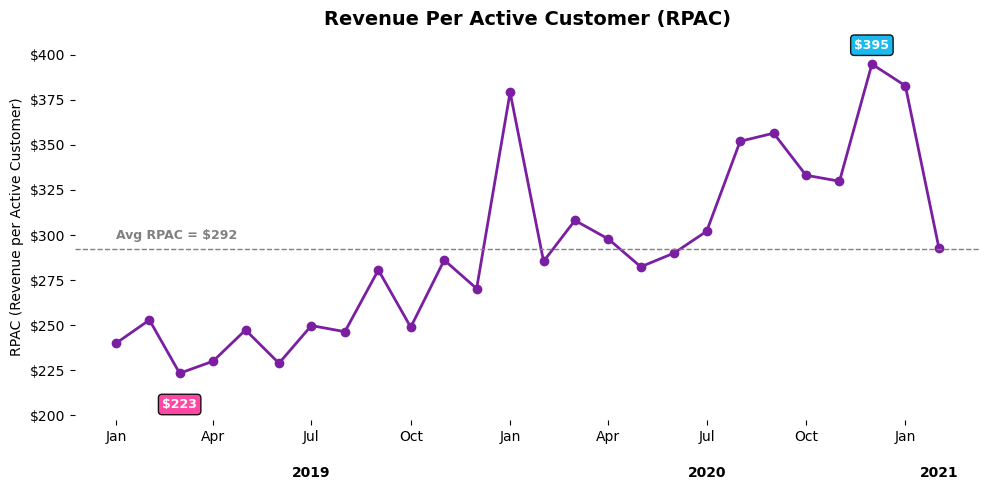

In [5]:
# --- Visualization ---
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]  # purple, blue, pink

plt.figure(figsize=(10, 5))
plt.plot(monthly_metrics['year_month'], monthly_metrics['RPAC'], marker='o', color=colors[0], linewidth=2)

plt.title('Revenue Per Active Customer (RPAC)', fontsize=14, fontweight='bold')
plt.ylabel('RPAC (Revenue per Active Customer)')
plt.xlabel('')

# Add $ sign to y-axis values
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

# Remove gridlines and chart outline
plt.grid(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add padding on y-axis
ymin, ymax = monthly_metrics['RPAC'].min(), monthly_metrics['RPAC'].max()
plt.ylim(ymin - (ymax - ymin) * 0.15, ymax + (ymax - ymin) * 0.1)

# Show only first month of each quarter (Jan, Apr, Jul, Oct)
quarter_months = monthly_metrics[monthly_metrics['year_month'].dt.month.isin([1, 4, 7, 10])]
plt.xticks(quarter_months['year_month'], quarter_months['year_month'].dt.strftime('%b'), rotation=0)

# --- Reference line for average RPAC ---
avg_rpac = monthly_metrics['RPAC'].mean()
plt.axhline(y=avg_rpac, color='grey', linestyle='--', linewidth=1)
plt.text(
    monthly_metrics['year_month'].min(), avg_rpac * 1.02,
    f'Avg RPAC = ${avg_rpac:.0f}',
    color='grey',
    fontsize=9,
    fontweight='bold'
)

# --- Label highest and lowest values ---
highest = monthly_metrics.loc[monthly_metrics['RPAC'].idxmax()]
lowest = monthly_metrics.loc[monthly_metrics['RPAC'].idxmin()]

# Highest (above line)
plt.text(
    highest['year_month'],
    highest['RPAC'] + (ymax - ymin) * 0.04,
    f"${highest['RPAC']:.0f}",
    ha='center',
    va='bottom',
    fontsize=9,
    fontweight='bold',
    color='white',
    bbox=dict(facecolor=colors[1], alpha=0.9, boxstyle='round,pad=0.3')
)

# Lowest (below line)
plt.text(
    lowest['year_month'],
    lowest['RPAC'] - (ymax - ymin) * 0.08,
    f"${lowest['RPAC']:.0f}",
    ha='center',
    va='top',
    fontsize=9,
    fontweight='bold',
    color='white',
    bbox=dict(facecolor=colors[2], alpha=0.9, boxstyle='round,pad=0.3')
)

# --- Add year labels below the x-axis ---
years = monthly_metrics['year_month'].dt.year.unique()
for yr in years:
    year_data = monthly_metrics[monthly_metrics['year_month'].dt.year == yr]
    if not year_data.empty:
        mid_month = year_data['year_month'].iloc[len(year_data)//2]
        plt.text(
            mid_month,
            ymin - (ymax - ymin) * 0.30,
            str(yr),
            ha='center',
            va='top',
            fontsize=10,
            fontweight='bold',
            color='black'
        )

plt.tight_layout()
plt.show()
